##Install Trax and transformers 
Trax is not compatible with Windows 

In [ ]:
!pip install transformers
!pip install trax 

##Import libraries

In [ ]:
import trax
from trax import layers as tl
import trax.fastmath.numpy as fastnp
from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel

#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base")
np.random.seed(123456)

###Data infos

In [ ]:

# Replace the path with your own. 
filenames_v0 = next(walk("./data/test_files_v0" ), (None, None, []))[2] 
filenames_v12 = next(walk("./data/test_files_v12" ), (None, None, []))[2] 

categories =  {}
for file in filenames_v0:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
      categories[label] = 0
    categories[label] += 1 

for file in filenames_v12:
    label = (file.split("@")[1]).split('.')[0].strip().lower() 
    if label not in categories.keys() : 
      categories[label] = 0
    categories[label] += 1   
    
print("\n==> All data : \n")
for x , y in categories.items() :
  print(x , y)

Mounted at /content/drive

==> All data : 

unordered collections 153
time 122
async wait 376
concurrency 144
network 93
i_o 6
randomness 50
test order dependency 291
test case timeout 42
too restrictive range 9
resource leak 28
floating point operations 9
platform dependency 6


##Transform source code to vectors

In [ ]:
def code_to_vector (  tests_path ) : 
  '''
  inputs 
  tests_path : location of code files 

  outputs
  short_tests : Dictionary of test vectors with less than 512 tokens 
  long_tests : Dictionary of test vectors with  more than 512 tokens 

  '''
  short_tests = { }
  long_tests  =  {}
  filenames = next(walk(tests_path ), (None, None, []))[2] 
  for file in filenames : 
      parts =  []
      f = open(os.path.join(tests_path, file), 'r', encoding="utf8")
      label = (file.split("@")[1]).split('.')[0].strip().lower() 
      lines = f.readlines()
      code = ""
      name = file.split("@")[0]
      for line in lines :
        if not "@Test"  in line : 
          code = code + " " + " ".join( line.strip().split())
      code_tokens=tokenizer.tokenize( code , return_tensors="pt")
      tokens = [tokenizer.cls_token] + code_tokens  + [tokenizer.sep_token]
      
      # codeBERT input is limited to 512 tokens including special tokens
      if(len(tokens) < 512) :      
          tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
          cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
          vector = cls[0].detach().numpy()
          if ( not label in short_tests.keys() ) :
              short_tests[label] = dict()
          short_tests[label][name] = vector
         
      else :
          i = 0 
          while ( i < len(code_tokens)-200) :
            tokens = [tokenizer.cls_token] + code_tokens[i:i+250] +[tokenizer.sep_token]
            tokens_ids= tokenizer.convert_tokens_to_ids(tokens)
            cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
            vector = cls[0].detach().numpy()
            parts.append( vector)
            i = i+100
          if ( not label in long_tests.keys() ) :
              long_tests[label] = dict()
          long_tests[label][name] = parts
      f.close()
  return short_tests , long_tests


In [ ]:
# Replace the path with the placement of the data files in your project. 
short_data , large_data = {} , {} 
short_data , large_data  = code_to_vector('./data/test_files_v0/')

# Generated data
generated_short_data , generated_large_data = {} , {} 
generated_short_data , generated_large_data = code_to_vector('./data/test_files_v12/')

###Import saved data vectors

In [ ]:
#Replace the path with your own
VectorsFolder = "./data/vectors/"
with open(VectorsFolder + "short_original_data.txt", 'r') as f:
    short_data = json.loads (json.load(f) )
with open(VectorsFolder + "large_original_data.txt", 'r') as f:
    large_data  = json.loads (json.load(f) )
with open(VectorsFolder + "short_generated_data.txt", 'r') as f:
    generated_short_data  = json.loads ( json.load(f) )
with open(VectorsFolder + "large_generated_data.txt", 'r') as f:
    generated_large_data  = json.loads (json.load(f))

###Save data vectors

In [ ]:
#make ndarrays serializables
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


# Replace the path with the placement of the data files

VectorsFolder = "./data/vectors/"


with open(VectorsFolder + "short_original_data.txt", 'w') as f:
    json.dump( json.dumps(short_data , cls=NumpyEncoder), f)
with open(VectorsFolder + "large_original_data.txt", 'w') as f:
    json.dump(json.dumps(large_data, cls=NumpyEncoder) , f)
with open(VectorsFolder + "short_generated_data.txt", 'w') as f:
    json.dump(json.dumps(generated_short_data, cls=NumpyEncoder), f)
with open(VectorsFolder + "large_generated_data.txt", 'w') as f:
    json.dump(json.dumps(generated_large_data , cls=NumpyEncoder), f)


## Secondary functions 

In [ ]:
# merge a list of dictionaries
def merge_dicts(dict_args):
  '''
  inputs 
  dict_args : list of dictionaries to merge 

  outputs 
  result : merged dictionary

  '''
  result = {}
  for dictionary in dict_args:
    for k , v in dictionary.items() :
      if ( k not in result.keys()):
        result[k] = {}
      for x , y in v.items() :
        result[k][x] = y
  return result


# calculate the cosine similarity
def cos_similarity (x , y ) : 
  '''
  x , y : two vectors with the same dimension
  return the cosine similarity between x and y
  
  '''
  x = normalize(fastnp.array(x))
  y = normalize(fastnp.array(y))
  if(x.ndim > 1 ): 
    return fastnp.diagonal(fastnp.dot(x, y.T) )  
  else :
    return fastnp.dot(x, y.T) 



# nomalize a matrix 
def normalize(x):  
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))

# the most frequent element in a list
def most_frequent(List):
    return max(set(List), key = List.count)


# calculate AUC for multi-class problems
def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)


# divide the data into training and test data 

def divide_data ( X , rate ) : 
  np.random.seed(123456)
  train_data , test_data =  dict() , dict()
  for key , value in X.items() : 
     l = list(value.items())
     np.random.shuffle(l)
     value = dict(l)
     number = int(round(rate*len(value.keys())))
     test_data[key] , train_data[key] = dict(list(value.items())[:number])  ,  dict(list(value.items())[number:])  

  return train_data , test_data 



def shuffle_dict(dic) :
  ls = list(dic.items())
  np.random.shuffle(ls)
  dic = dict(ls)
  return dic

##Filter and split data

In [ ]:
#Consider data with more than 30 examples.
#data use the following  format :  {"flakiness category" : {"testName1" : codeBERT vector , ........} , .......}

data = dict()
for x , y in short_data.items() :
   if len(y) >= 30 : 
     data[x] = y

generated_data= dict()
for x , y in generated_short_data.items() :
   if (x in data.keys()) : 
     generated_data[x] = y

long_data = dict()
for x , y in large_data.items() :
   if (x in data.keys()) : 
     long_data[x] = y
  

X_train , X_test = divide_data(data , 0.25)



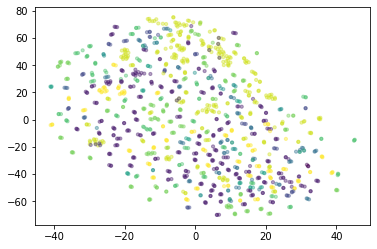

In [ ]:

%matplotlib inline

X= []
labels = []
d = merge_dicts([short_data, generated_short_data])
for k , v in d.items() : 
  X = X + list(v.values())
  labels = labels + ( [k] * len(v) )

labelsdic = {list ( set (labels)) [i]: i for i in range(len(list ( set (labels)) ))}
labelsNums = [ labelsdic [l] for l in labels  ]
X_embedded= TSNE(n_components=2, init='random').fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap='viridis' , alpha=0.4 );


### Stratified k-folds

In [ ]:
def K_folds(data_to_divide , folds_number =10) :
  '''
  inputs 
  data_to_divide : dictionary to split into k folds 
  folds_number : number of folds to return 

  outputs 
  folds_tab : list of dictionaries
  
  '''
  folds_tab =   [{} for i in range(folds_number)]
  for k , v in data_to_divide.items() : 
    l = list(v.items())
    np.random.shuffle(l)
    v = dict(l)
    tab_names = np.array_split( list(v.keys()) , folds_number) 
    tab_vectors=  np.array_split( list( v.values() ) , folds_number) 
    for i in range(folds_number) : 
      if ( k not in folds_tab[i].keys()):
        folds_tab[i][k] = dict()
      for j in range(len(tab_names[i])) : 
        folds_tab[i][k][tab_names[i][j]] = tab_vectors[i][j]
  return  folds_tab


## Define the Data generator
trax uses only genearators to train its models 

In [ ]:
def data_generator(X, batch_size):
    '''
    inputs
    X : data dictionary
    batch_size : number of examples in each batch

    outputs
    batch1 , batch 2 : two batches ready to be used by the Siamese model  

    '''
    batch1 = []
    batch2 = []
    while True:
      for x , y in X.items():
        comb = sample ( list(combinations(  range ( 0 ,len(y.keys()) -1 )  , 2))  ,1 )[0]

        #lines of the same level have data of the same category
        batch1.append( np.array( list(y.values())[comb[0]]).reshape(768) )
        batch2.append( np.array( list(y.values())[comb[1]]).reshape(768) )
      if len(batch1) == batch_size:
          yield  np.array(batch1), np.array(batch2) 
          batch1, batch2 = [], [] 

##Siamese Model

In [ ]:
def Siamese( mode='train'):

    def normalize(x):  
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    processor = tl.Serial( 
      
        tl.Dense(512) ,
        tl.Fn('Normalize', lambda x: normalize(x))
    ) 
    
    model = tl.Parallel(processor, processor)
    return model

model = Siamese()

##Triplet Loss function

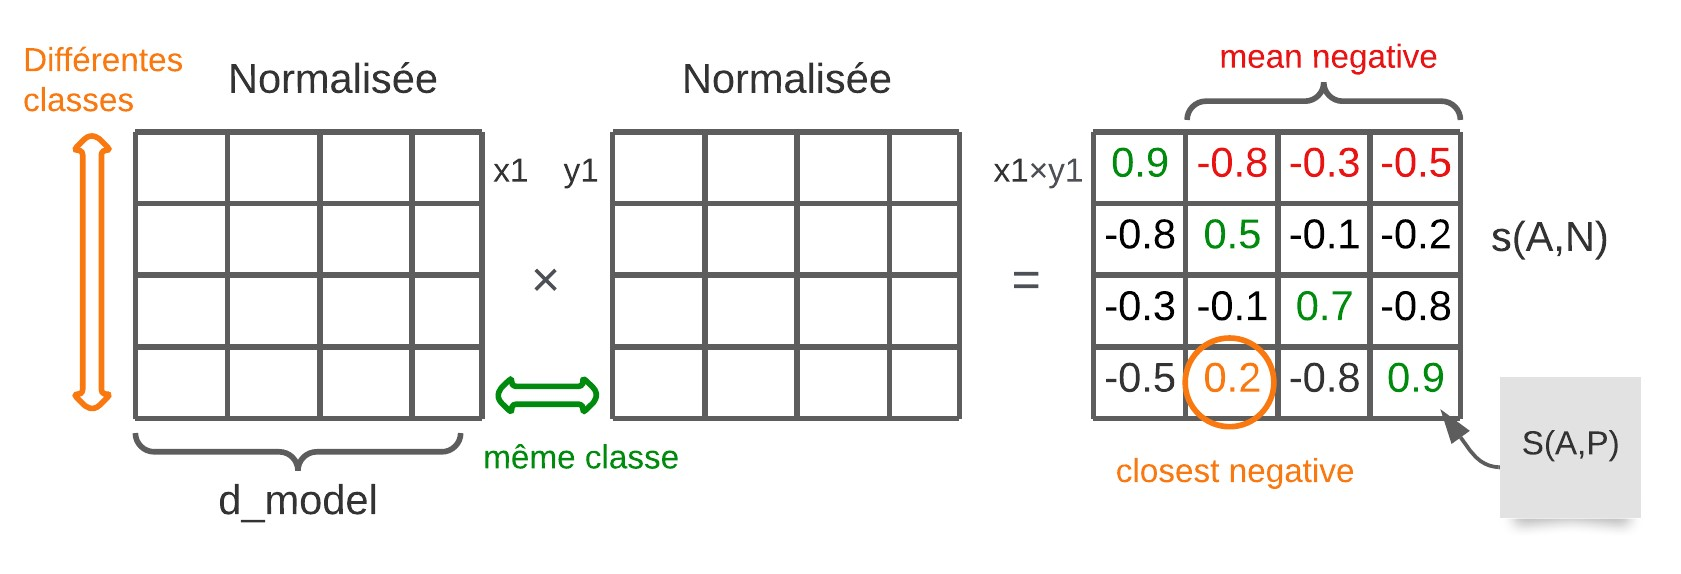

In [ ]:

def TripletLossFn(v1, v2, margin=0.3):

    '''
    v1 , v2 : two matrixes ( batches ) with the same dimension
    return the Triplet Loss between x and y = max( 0 , s(A,closest_negatif) - s(A,P) + margin ) + max( 0 , s(A,mean_negatif) - s(A,P) + margin )

    '''
    v1 = normalize(v1)
    v2 = normalize(v2)
    scores = fastnp.dot(v1, v2.T) 
    batch_size = len(scores)
    positive = fastnp.diagonal(scores) 
    negative_without_positive = scores - 2.0 * fastnp.eye(batch_size) 
    closest_negative = negative_without_positive.max(axis=1)
    negative_zero_on_duplicate = scores * (1.0 - fastnp.eye(batch_size))
    mean_negative = np.sum(negative_zero_on_duplicate, axis=1) / (batch_size-1)
    triplet_loss1 = fastnp.maximum(0.0, margin - positive + closest_negative)
    triplet_loss2 = fastnp.maximum(0.0, margin - positive + mean_negative)
    triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)
    return triplet_loss


#transform into a trainable function. 
def TripletLoss(margin=0.3):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return tl.Fn('TripletLoss', triplet_loss_fn)

#Train function

In [ ]:
def train_model(TripletLoss, sim_margin , lr , n_warmup_steps, train_generator , output_dir):

  '''
  inputs 
  TripletLoss :  loss function
  sim_margin : the similarity margin used in the triplet loss function ( )
  train_generator : training data generator 
  output_dir : dir where to save trained model

  outputs 
  trainning_loop : loop object ready to run for n times and train the model
  
  '''
  lr_schedule = trax.lr.warmup_and_rsqrt_decay( n_warmup_steps, lr)
  train_task = training.TrainTask( 
      labeled_data= train_generator,     
      loss_layer= TripletLoss(sim_margin),      
      optimizer=trax.optimizers.Adam(lr), 
      n_steps_per_checkpoint=1000,       
      lr_schedule=lr_schedule 
    )
    

  # you can do validation step if you have enough data
  #eval_task = training.EvalTask(
  #labeled_data=train_generator,      
  #metrics=[TripletLoss() ],         
  #)
    
  training_loop = training.Loop(Siamese(),
                                train_task,
                                #eval_tasks=[eval_task],
                                output_dir=output_dir,
                                random_seed = 123456 )

  return training_loop

##Select support set

In [ ]:

def get_support_set(data , model , number): 
  '''
  inputs 
  data : data to select 
  model :  siamese model to transform the data 
  number : number of examples for each flakiness category

  outputs 
  support_set : selected support_set , the most central data 

  '''
  model_vectors = dict()
  support_set = dict()
  for key , value in data.items():
    model_vectors[key] = {}
    for test in value.keys() : 
      try : 
        v = model(( np.array(data[key][test]) , np.array(data[key][test] )) )[0]
        model_vectors[key][test] = v 
      except : 
        print(data[key][test])

  means_names = {}
  for key , value in model_vectors.items():
    mean_point = np.mean( list(model_vectors[key].values()) , axis=0)
    distances = []
    for cle in value.keys() :  
      distances.append( [ distance.euclidean( mean_point , model_vectors[key][cle]) ,  cle] ) 
    distances.sort(key=lambda tab: tab[0])
    means_names[key] = [ elem[1]  for elem in distances[:number]]
    support_set[key] = dict()
    for Name in means_names[key] : 
      support_set[key][Name] = data[key][Name]

    
  return support_set


##FSL Classifier 

In [ ]:
def smallTestsclassifier(   model,  query  ,  support_set  ):
  '''
  inputs 
  model : Siamese model
  query : the examplt to classify
  support_set : examples for each category

  outputs 
  SimilarityDic : the similarity scores calculated for each category
  label : predicted label 

  '''

  matrix_similarities = []
  SimilarityDic= {}
  for key , value in support_set.items() : 
      y = np.matrix(list(value.values()))
      x1 = [query] * y.shape[0]
      x1 = np.matrix(x1)
      v1, v2 = model( ( x1 , y ) )
      v1 =  normalize(v1)
      v2 = normalize(v2)
      sim = np.dot(v1, v2.T)
      d =   np.mean( np.diag ( sim ))  
      SimilarityDic[key] = d 
  label = max(SimilarityDic, key=SimilarityDic.get)

  return  SimilarityDic , label


In [ ]:
def longTestsClassifier ( model,  query ,  support_set ) :
  '''
  inputs 
  model : Siamese model
  query : the examplt to classify
  support_set : examples for each category

  outputs 
  SimilarityDictionnary : the similarity scores calculated for each category
  most_frequent(labels_predicted) : predicted label 

  '''
  
  labels_predicted =  []
  for TestPart in query : 
    SimilarityDictionnary , label = smallTestsclassifier(model , TestPart  , support_set)
    SimilarityValues  = list ( SimilarityDictionnary.values() )
    SimilarityValues.sort(reverse=True)
    if SimilarityValues[0]  > 0.6 :
      labels_predicted.append(label)
  return  SimilarityDictionnary , most_frequent(labels_predicted)

In [ ]:
def classifier (model,  test_data  ,  support_set) :

  '''
  inputs 
  model : Siamese model
  query : data to classify
  support_set : examples for each category

  outputs 
  predictedLabels : predicted labels for test data
  Sim_matrix : similarity scores 
  '''
  Sim_matrix =  []
  predictedLabels =  [] 
  for query in test_data : 
    if len(query )== 768  : 
      score , label  = smallTestsclassifier ( model , query , support_set)
    else : 
      score, label  = longTestsClassifier ( model , query , support_set)
    predictedLabels.append(label)
    Sim_matrix.append(score)
  return predictedLabels , Sim_matrix

### 10-folds cross validation

In [ ]:
def cross_validation(train_steps , dir_name ,data_dic , data_augmented , learning_rate ,  n_warmup_steps , sim_margin , size_support_set) : 
  '''
  Inputs 
  train_steps : number of iterations
  dir_name : folder where to save the trained model
  data_dic : train data
  data_augmented :  generated data 
  learning_rate : learning rate for the siamese model
  sim_margin : similarity margin used on the loss function
  size_support_set : number of examples representing each category in the support_set


  outputs 
  f1_global : global f1 score using the 10-folds cross validation 
  
  '''

  np.random.seed(123456)
  metrics_dict , support_set = {} , {}
  metrics_dict["f1_score"]  = [] 
  f1_score_per_class = []
  batch_size = len(list(data_dic.keys()))
  folds_array = K_folds(data_dic , 10)
  for i in range(len(folds_array )):
      eval_data = folds_array[i]
      train_data  = merge_dicts (folds_array[0:i] + folds_array[i+1:len(folds_array)])
      original_train_data = copy.deepcopy(train_data)

      # Add the data generated after the split to not include similar copies in the train and test
      for label , value in data_augmented.items() :
        for test_name  , vector in value.items() : 
          if ( test_name[3:] in train_data[label].keys() ) : 
            train_data[label][test_name] = data_augmented[label][test_name]
          if ( test_name[3:] in eval_data[label].keys() ) : 
            eval_data[label][test_name] = data_augmented[label][test_name]
      train_generator = data_generator(train_data , batch_size)
      !rm -rf model
      training_loop = train_model( TripletLoss,  sim_margin , learning_rate,  n_warmup_steps , train_generator , "model/")
      training_loop.run(train_steps)
      #-------------------------------------------------------------------------------
      model = Siamese()
      model.init_from_file('model/model.pkl.gz')
      test_data_array =  []
      labels = []
      for label , vec in eval_data.items():
        test_data_array = test_data_array + list(vec.values())
        labels = labels + [label] * len(list(vec.values()))
      unique_labels = list ( set(labels ) )
      support_set =  get_support_set(original_train_data , model , size_support_set)
      predicted  , m = classifier(model , test_data_array  , support_set)
      
      #print (classification_report(labels, predicted))
      metrics_dict["f1_score"].append( metrics.f1_score(labels,  predicted ,  average='weighted'))

  f1_global =  np.round(np.average(metrics_dict["f1_score"]) , 2)

  return  f1_global
  

In [ ]:
warnings.filterwarnings("ignore")
output_dir = os.path.expanduser('~/model/')
train_data = copy.deepcopy(X_train)
F1_result  = cross_validation(10000, output_dir , train_data , generated_data ,learning_rate = 0.001 ,  n_warmup_steps = 400, sim_margin=0.30 , size_support_set= 10)
print(F1_result)



### Parameters Tunning 

In [ ]:

def Random_Search ( data , generated_data  ,  max_iter,  percent= 0.3  ) : 
      
    max_score = 0  
    best_solution= None
    output_dir =  os.path.expanduser('~/model/')
    scores = list()
    learning_rates = [ 0.001 , 0.01 , 0.1 ]
    n_warmup = [400 , 600 , 800 ]
    sim_margin =  [ 0.22 , 0.25 , 0.27 , 0.28 , 0.3 ]
    support_set_size  = [  2, 10 , 15 ]
    parameters = []        
    for j in learning_rates :   
       for i in n_warmup :    
          for x in  sim_margin : 
            for y in  support_set_size  : 
              parameters.append( ( j, i , x , y) )
    n = int(len(parameters) * percent)
    reduced_grid = sample(parameters, n)
    print(reduced_grid)
    n_iter = 0 
    for k in range( len( reduced_grid  ) ) : 
      if   n_iter < max_iter : 
        n_iter += 1 
        curr_score =    cross_validation( 10000 , output_dir , data , generated_data ,reduced_grid[k][0] , reduced_grid[k][1]  , reduced_grid[k][2] ,  reduced_grid[k][3])           
        scores.append([reduced_grid[k] , curr_score ])
        print("\n Result for combination " , reduced_grid[k] , " : " , curr_score )
        if max_score < curr_score :            
          max_score = curr_score
      else : 
        break       
    return max_score , best_solution , scores
     

In [ ]:
warnings.filterwarnings("ignore")
rnd.seed(123456)
train_data = copy.deepcopy(X_train)
best_score , best_solution , scores_to_plot = Random_Search( train_data , generated_data  ,  15 ,  percent= 0.2  )

[(0.01, 600, 0.3, 15), (0.001, 400, 0.27, 10), (0.001, 800, 0.3, 15), (0.001, 400, 0.22, 2), (0.001, 600, 0.25, 10), (0.001, 400, 0.3, 10), (0.01, 600, 0.27, 15), (0.1, 800, 0.3, 10), (0.001, 400, 0.3, 15), (0.1, 600, 0.3, 15), (0.001, 600, 0.3, 15), (0.01, 800, 0.27, 2), (0.01, 600, 0.22, 15), (0.1, 600, 0.28, 10), (0.001, 600, 0.27, 15), (0.1, 600, 0.3, 2), (0.001, 400, 0.25, 2), (0.01, 600, 0.27, 10), (0.1, 600, 0.28, 15), (0.001, 600, 0.22, 10), (0.01, 400, 0.25, 2), (0.1, 600, 0.27, 2), (0.01, 800, 0.27, 10), (0.1, 400, 0.28, 10), (0.01, 400, 0.22, 15), (0.001, 400, 0.25, 15), (0.1, 800, 0.22, 2)]

 Result for combination  (0.01, 600, 0.3, 15)  :  0.65

 Result for combination  (0.001, 400, 0.27, 10)  :  0.67

 Result for combination  (0.001, 800, 0.3, 15)  :  0.65

 Result for combination  (0.001, 400, 0.22, 2)  :  0.67

 Result for combination  (0.001, 600, 0.25, 10)  :  0.67

 Result for combination  (0.001, 400, 0.3, 10)  :  0.67

 Result for combination  (0.01, 600, 0.27, 15)

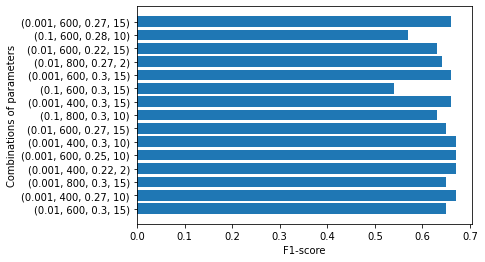

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
y , x = [] , []
for item in scores_to_plot : 
  y.append(str(item[0]))
  x.append(item[1])

plt.barh(y, x)
plt.ylabel("Combinations of parameters")

plt.xlabel("F1-score")
plt.show()


#Final validation on holdout set

### Train model

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")
sim_margin = 0.3
learning_rate = 0.001
batch_size =  len(X_train.keys())
train_steps = 10000
size_support_set = 10
n_warmup_steps = 400
np.random.seed(123456)
test_data = copy.deepcopy(X_test)
train_data = copy.deepcopy (X_train) 
for label , value in generated_data.items() :
  for test_name  , vector in value.items() : 
    if ( test_name[3:] in train_data[label].keys() ) : 
        train_data[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_data[label].keys() ) : 
        test_data[label][test_name] = generated_data[label][test_name]

print("\n\n ==> Train data : \n")
for x , y in train_data.items(): 
  print(x , len(y.keys()))
train_generator = data_generator(train_data, batch_size)
!rm -rf model
training_loop = train_model(TripletLoss,  sim_margin , learning_rate, n_warmup_steps, train_generator , "model/")
print("\n\n=> Training in progress ...")
training_loop.run(train_steps)
print("\n=> Training finished")




 ==> Train data : 

unordered collections 108
time 80
async wait 220
concurrency 90
test order dependency 217




=> Training in progress ...

=> Training finished


### Test model

                       precision    recall  f1-score   support

           async wait       0.72      0.92      0.81        71
          concurrency       0.41      0.37      0.39        30
test order dependency       0.94      0.70      0.80        67
                 time       0.65      0.67      0.66        30
unordered collections       0.78      0.78      0.78        36

             accuracy                           0.73       234
            macro avg       0.70      0.69      0.69       234
         weighted avg       0.74      0.73      0.73       234


 - Accuracy :  0.73
 - Precision :  0.74
 - Recall :  0.73
 - F1 score :  0.73
 - MCC :  0.65
 - AUC :  0.83


Perfomnaces by categories



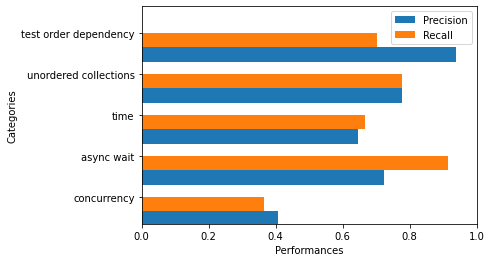



Confusion Matrix 


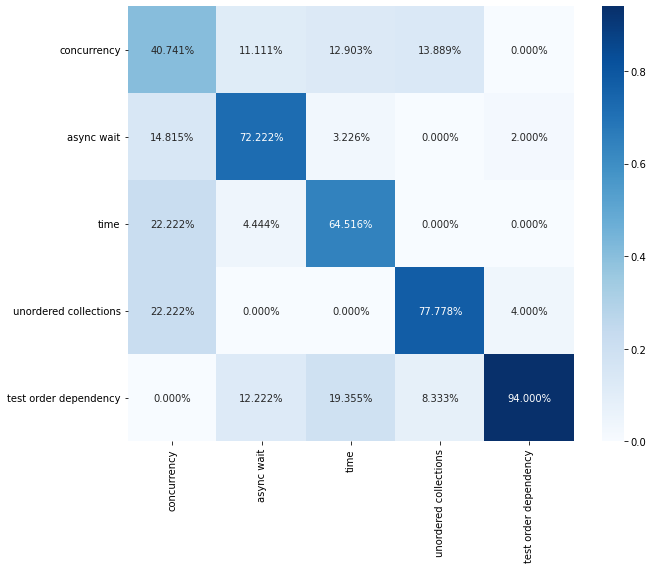

In [ ]:
model = Siamese()
model.init_from_file("model/model.pkl.gz")
test_data_array =  []
labels = []
for label , vec in test_data.items():
  test_data_array = test_data_array + list(vec.values())
  labels = labels + [label] * len(list(vec.values()))
unique_labels = list ( set(labels ) )
support_set =  get_support_set(X_train , model , size_support_set)
predicted , sim_scores  = classifier(model , test_data_array  , support_set)
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='upper right')
ax.set_xlabel("Performances")
ax.set_ylabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

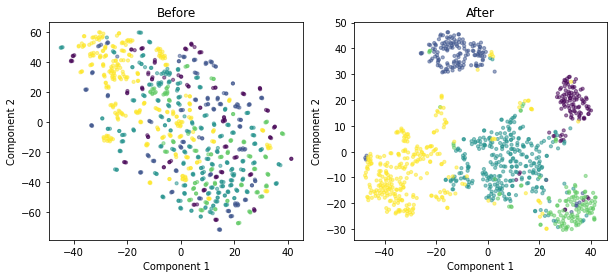

In [ ]:
%matplotlib inline
model = Siamese()
model.init_from_file('model/model.pkl.gz')
X= []
labels = []
X_1 = []
d = merge_dicts([data, generated_data])
for k , v in d.items() : 
  X = X + list(v.values())
  labels = labels + ( [k] * len(v) )
labelsdic = {list ( set (labels)) [i]: i for i in range(len(list ( set (labels)) ))}
labelsNums = [ labelsdic [l] for l in labels  ]
i=0
while i < len(X)-1: 
  x = np.array(X[i])
  y = np.array(X[i+1])
  i  +=  2 
  v1  , v2 = model((x , y ))
  X_1.append(v1)
  X_1.append(v2)
X_1 = np.array(X_1)
X_embedded_2= TSNE(n_components=2, init='random').fit_transform(X_1)
X_embedded_1= TSNE(n_components=2, init='random').fit_transform(X)
fig , (ax1 , ax2) = plt.subplots(1,2, figsize=(10, 4))
ax1.scatter(X_embedded_1[:, 0], X_embedded_1[:, 1] , c=labelsNums[:len(X_embedded_1)], s=10 ,  cmap='viridis' , alpha=0.5)
ax2.scatter(X_embedded_2[:, 0], X_embedded_2[:, 1] , c=labelsNums[:len(X_embedded_2)], s=10 ,  cmap='viridis' , alpha=0.5)
ax1.set_xlabel('Component 1')
ax1.set_ylabel('Component 2')
ax1.set_title("Before")
ax2.set_title("After")
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
plt.show()


### Adding more classes




 ==> Train data : 

unordered collections 108
time 80
async wait 220
concurrency 90
network 19
test order dependency 213


=> Training in progress ...

=> Training finished
                       precision    recall  f1-score   support

           async wait       0.80      0.66      0.72        71
          concurrency       0.33      0.40      0.36        30
              network       0.27      0.67      0.38         6
test order dependency       0.70      0.76      0.73        71
                 time       1.00      0.60      0.75        30
unordered collections       0.69      0.75      0.72        36

             accuracy                           0.66       244
            macro avg       0.63      0.64      0.61       244
         weighted avg       0.71      0.66      0.68       244


 - Accuracy :  0.66
 - Precision :  0.71
 - Recall :  0.66
 - F1 score :  0.68
 - MCC :  0.57
 - AUC :  0.79


Perfomnaces by categories



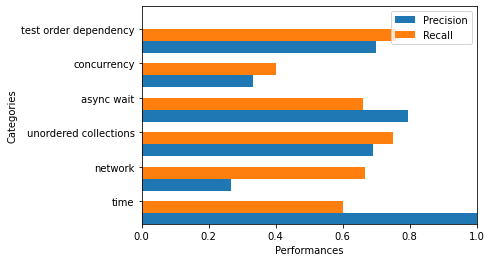



Confusion Matrix 


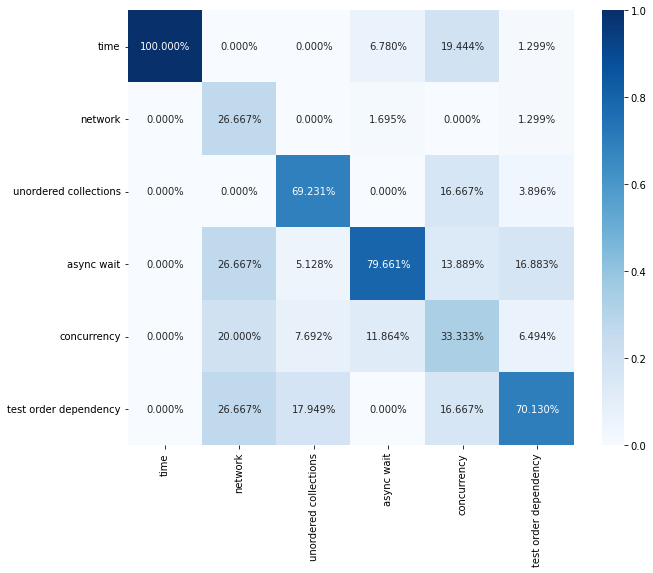

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")


data_1 = dict()
for x , y in short_data.items() :
   if len(y) >= 15 : 
     data_1[x] = y

train_data_1 ,test_data_1 = divide_data(data_1 , 0.25)


sim_margin = 0.30
learning_rate = 0.001
batch_size =  len(train_data_1.keys())
train_steps = 10000
size_support_set = 10
n_warmup_steps = 400
np.random.seed(123456)


for label , value in generated_data.items() :
  for test_name  , vector in value.items() : 
    if ( test_name[3:] in train_data_1[label].keys() ) : 
        train_data_1[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_data_1[label].keys() ) : 
        test_data_1[label][test_name] = generated_data[label][test_name]

print("\n\n ==> Train data : \n")
for x , y in train_data_1.items(): 
  print(x , len(y.keys()))
train_generator = data_generator(train_data_1, batch_size)
!rm -rf model1
training_loop = train_model(TripletLoss,  sim_margin , learning_rate, n_warmup_steps, train_generator , "model1/")
print("\n\n=> Training in progress ...")
training_loop.run(train_steps)
print("\n=> Training finished")


model = Siamese()
model.init_from_file("model1/model.pkl.gz")
test_data_array =  []
labels = []
for label , vec in test_data_1.items():
  test_data_array = test_data_array + list(vec.values())
  labels = labels + [label] * len(list(vec.values()))
unique_labels = list ( set(labels ) )
support_set =  get_support_set(train_data_1 , model , size_support_set)
predicted , sim_scores  = classifier(model , test_data_array  , support_set)
print (classification_report(labels, predicted))

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(labels,  predicted) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(labels,  predicted , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(labels,  predicted , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(labels,  predicted , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(labels,  predicted) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(labels,  predicted),2) )

print("\n\nPerfomnaces by categories\n")


ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[0]
recall = metrics.precision_recall_fscore_support(labels,  predicted ,  labels=unique_labels )[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
ylim=[2*width - 1, len(ind)])
plt.xlim(0,1)
ax.legend(loc='upper right')
ax.set_xlabel("Performances")
ax.set_ylabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(labels,  predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index = [i for i in unique_labels], columns = [i for i in unique_labels])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')

### Model explainability

In [ ]:
def delete_spaces(lines) : 
  code = ""
  for line in lines :
        if not "@Test"  in line : 
          code = code + " " + " ".join( line.strip().split()) + ";"

  return code 

In [ ]:
import csv
data_folder =  './data/test_files_v0/'
csvFile = open('./data/statments.csv', 'w')
writer = csv.writer(csvFile)
used_data = list()
for classe in data.keys() :
  used_data = used_data +  list(data[classe].keys()) 

filenames = next(walk(data_folder), (None, None, []))[2] 

for file in filenames : 
  if file.split("@")[0] in used_data :
      parts =  []
      label = (file.split("@")[1]).split('.')[0].strip().lower() 
      f = open(os.path.join(data_folder, file), 'r', encoding="utf8")
      label = (file.split("@")[1]).split('.')[0].strip().lower()
      code_string = f.read()
      j = 1 
      temp = []
      code = delete_spaces(code_string.split(";"))
      lines = code.split(";")
      code_deleted_line = ""
      nb_lines = len(lines) -1 
      code_tokens=tokenizer.tokenize( code , return_tensors="pt")
      tokens = [tokenizer.cls_token] + code_tokens  + [tokenizer.sep_token]
      if(len(tokens) < 512) : 
          tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
          cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
          vector = cls[0].detach().numpy()
          predicted , similarity_matrix  =  classifier(model , [vector]  , support_set)  
          #print("_______________________________________________________________________________________________________________________________________________")
          #print("\n" ,file.split("@")[0] ,"\t" , label   ) 
          #print("Predicted label with complet code :" , predicted[0] , similarity_matrix[0]  ,  "\n" ) 
          predicted_with_complete_code = predicted[0]
          statment_min_sim = ""
          initial_score =  similarity_matrix [0][predicted_with_complete_code]
          min_similarity =  similarity_matrix [0][predicted_with_complete_code]
            
          while j < nb_lines :
              code = ""
              temp= lines[0:j] + lines[j+1:]
              deleted_line = lines[j]
              code = delete_spaces(temp)
              code_tokens=tokenizer.tokenize( code , return_tensors="pt")
              tokens = [tokenizer.cls_token] + code_tokens  + [tokenizer.sep_token]
              tokens_ids=tokenizer.convert_tokens_to_ids(tokens)
              cls = model_codebert(torch.tensor(tokens_ids)[None,:])[1]
              vector_v1 = cls[0].detach().numpy()
              predicted , similarity_matrix   = classifier(model , [vector_v1] , support_set)
              if similarity_matrix[0][predicted_with_complete_code] <= min_similarity and len(deleted_line) > 10 :
                  min_similarity = similarity_matrix[0][predicted_with_complete_code]
                  statment_min_sim = deleted_line.strip()
              j+=1
            
          #print( "====> \t" , statment_min_sim  , min_similarity  ,"\n")
          row = []
          row = [file.split("@")[0] , label  , predicted_with_complete_code , initial_score , min_similarity , statment_min_sim  ]
          writer.writerow(row)
       
      
csvFile.close()



## Random gessing

In [ ]:
import random as rnd
rnd.seed(123456)

def calculate_weights( X , classes) : 
  counts = [len(X[y]) for y in classes]
  return np.round( counts / np.sum(counts) , 2) 



labels_str = {
      "async wait" : 0 ,
      "concurrency" : 1 ,
      "time" : 2 ,
      "test order dependency" : 3 ,
      "unordered collections" : 4
}

weights = calculate_weights (X_train , list(labels_str.keys()))


original_labels = []
for label , vec in X_test.items():
  original_labels = original_labels + [labels_str[label] ] * len(list(vec.values()))


predicted_nums =  rnd.choices(list(labels_str.values()) ,  weights = None,  k = len(original_labels) )
weighted_predicted_nums =  rnd.choices(list(labels_str.values()) ,  weights = weights,  k = len(original_labels) )

print("Results for Random : \n\n")

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(original_labels , predicted_nums) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(original_labels , predicted_nums , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(original_labels , predicted_nums , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(original_labels , predicted_nums, average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(original_labels , predicted_nums) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(original_labels ,predicted_nums),2) )

print("\n\nResults for weighted Random : \n\n")

print('\n - Accuracy : ' , np.round( metrics.accuracy_score(original_labels , weighted_predicted_nums) , 2))
print(' - Precision : ' , np.round( metrics.precision_score(original_labels , weighted_predicted_nums , average='weighted') , 2))
print(' - Recall : ' , np.round( metrics.recall_score(original_labels , weighted_predicted_nums , average='weighted') , 2))
print(' - F1 score : ' , np.round( metrics.f1_score(original_labels , weighted_predicted_nums , average='weighted') , 2))
print(' - MCC : ' , np.round( metrics.matthews_corrcoef(original_labels , weighted_predicted_nums ) , 2))
print(' - AUC : ' , np.round( multiclass_roc_auc_score(original_labels , weighted_predicted_nums),2) )


Results for Random : 



 - Accuracy :  0.2
 - Precision :  0.25
 - Recall :  0.2
 - F1 score :  0.21
 - MCC :  -0.01
 - AUC :  0.5


Results for weighted Random : 



 - Accuracy :  0.26
 - Precision :  0.25
 - Recall :  0.26
 - F1 score :  0.25
 - MCC :  0.02
 - AUC :  0.51


## Classical classifiers 

In [ ]:
def eval_classifier (model ,  X_to_train , Y_to_train , test_set , test_labels ) : 
  model.fit( X_to_train , Y_to_train)
  y_pred = model.predict(test_set )
  print(classification_report(test_labels , y_pred))
  print('Accuracy' , np.round(metrics.accuracy_score(test_labels,  y_pred ), 2) )
  print('MCC' , np.round( metrics.matthews_corrcoef(test_labels, y_pred) , 2) )
  print('AUC' , np.round(multiclass_roc_auc_score(test_labels,  y_pred) , 2) )
  unique_labels = list ( set(test_labels  ) )
  ind = np.arange(len(unique_labels)) 
  width = 0.35
  fig, ax = plt.subplots()
  precision = metrics.precision_recall_fscore_support(test_labels,  y_pred ,  labels=unique_labels )[0]
  recall = metrics.precision_recall_fscore_support(test_labels, y_pred ,  labels=unique_labels )[1]
  ax.barh(ind - width/2, precision, width, label='Precision')
  ax.barh(ind + width/2, recall, width, label='Recall')
  ax.set(yticks=ind + width, yticklabels=np.array(unique_labels),
  ylim=[2*width - 1, len(ind)])
  plt.xlim(0,1)
  ax.legend(loc='upper right')
  ax.set_xlabel("Performances")
  ax.set_ylabel("Catégories")
  plt.show()



#---------------------------------------------------------------------------------------------------------

%matplotlib inline
test_set = copy.deepcopy(X_test)
train_set = copy.deepcopy (X_train) 
for label , value in generated_data.items() :
  for test_name  , vector in value.items() : 
    if ( test_name[3:] in train_set[label].keys() ) : 
        train_set[label][test_name] = generated_data[label][test_name]
    if ( test_name[3:] in test_set[label].keys() ) : 
        test_set[label][test_name] = generated_data[label][test_name]

test_labels = []
test_set_to_array =  []
for label , vec in test_set.items():
  test_set_to_array= test_set_to_array + list(vec.values())
  test_labels  = test_labels  + [label] * len(list(vec.values()))
set_labels = list ( set(test_labels  ) )

X_to_train , Y_to_train =  [] , []
for label , values in train_data.items() :
        X_to_train = X_to_train + list(values.values())
        Y_to_train = Y_to_train + [label]*len(values.values())

### Random Forest

                       precision    recall  f1-score   support

           async wait       0.54      0.82      0.65        71
          concurrency       0.29      0.07      0.11        30
test order dependency       0.72      0.92      0.81        73
                 time       1.00      0.33      0.50        30
unordered collections       0.91      0.58      0.71        36

             accuracy                           0.66       240
            macro avg       0.69      0.54      0.56       240
         weighted avg       0.68      0.66      0.62       240

Accuracy 0.66
MCC 0.55
AUC 0.76


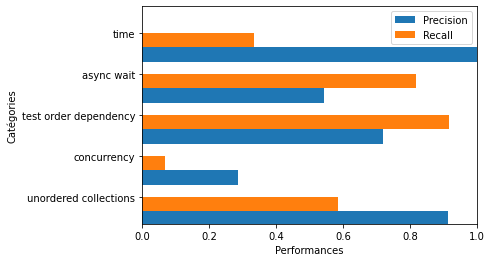

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, random_state=123456)

eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)


### Decision Tree

                       precision    recall  f1-score   support

           async wait       0.53      0.54      0.53        71
          concurrency       0.17      0.20      0.18        30
test order dependency       0.64      0.68      0.66        73
                 time       0.35      0.20      0.26        30
unordered collections       0.50      0.53      0.51        36

             accuracy                           0.50       240
            macro avg       0.44      0.43      0.43       240
         weighted avg       0.49      0.50      0.49       240

Accuracy 0.5
MCC 0.34
AUC 0.67


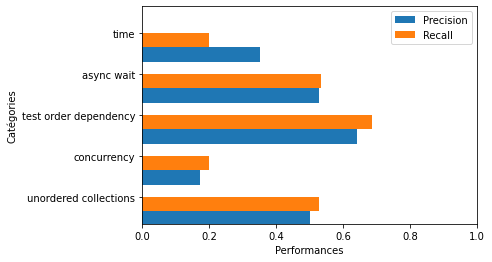

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)

### K-Nearest Neighbors

                       precision    recall  f1-score   support

           async wait       0.44      0.70      0.54        71
          concurrency       0.17      0.10      0.12        30
test order dependency       0.72      0.74      0.73        73
                 time       1.00      0.30      0.46        30
unordered collections       0.42      0.28      0.33        36

             accuracy                           0.53       240
            macro avg       0.55      0.42      0.44       240
         weighted avg       0.56      0.53      0.51       240

Accuracy 0.52
MCC 0.37
AUC 0.68


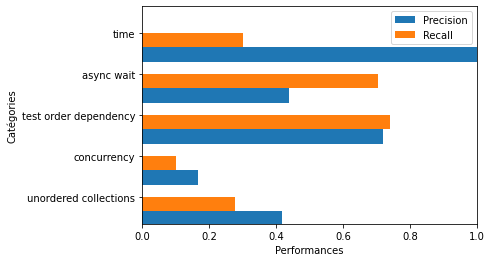

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier() 
eval_classifier (model , X_to_train , Y_to_train , test_set_to_array , test_labels)

### Support Vector Machine

                       precision    recall  f1-score   support

           async wait       0.36      0.76      0.49        71
          concurrency       0.00      0.00      0.00        30
test order dependency       0.54      0.68      0.61        73
                 time       0.00      0.00      0.00        30
unordered collections       0.00      0.00      0.00        36

             accuracy                           0.43       240
            macro avg       0.18      0.29      0.22       240
         weighted avg       0.27      0.43      0.33       240

Accuracy 0.43
MCC 0.22
AUC 0.6


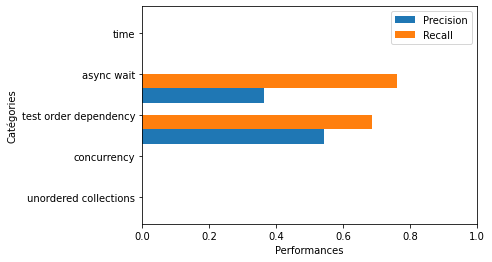

In [ ]:
from sklearn import svm
model = svm.SVC( C = 1. , kernel = 'rbf' , gamma  = 0.01)
eval_classifier (model , X_to_train , Y_to_train ,test_set_to_array , test_labels)